In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score


In [ ]:
#google colab drive mount code

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# reading data file

df = pd.read_csv('/content/gdrive/MyDrive/FINAL YR PROJECT/Fake News/Model/Data/fake_or_real_news.csv')


In [ ]:
df.head()

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
# read in our data and preprocess it

df.drop(labels=['id','title'], axis='columns', inplace=True)
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [ ]:
df.dropna(subset = ["text"], inplace=True)

In [ ]:
# Removing stopwords

from gensim.parsing.preprocessing import remove_stopwords
def stopword_removal(row):
    text = row['text']
    text = remove_stopwords(text)
    return text

In [ ]:
df['text'] = df.apply(stopword_removal, axis=1)

In [ ]:
# Converting text into smaller letters.

df['text'] = df['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

<ipython-input-9-b3aba37379ec>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [ ]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


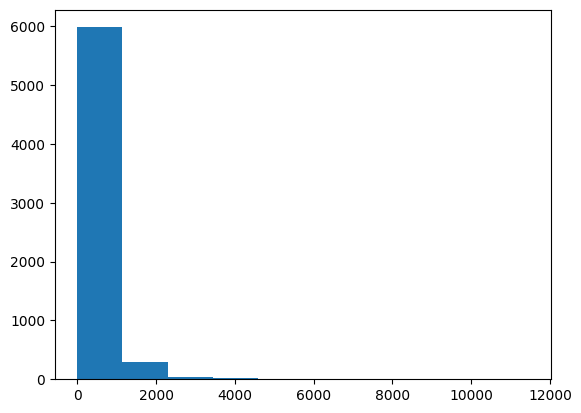

In [ ]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

In [ ]:
MAX_SEQUENCE_LENGTH = 700
MAX_NUM_WORDS = 1000
EMBEDDING_DIM = 64
TEST_SPLIT = 0.2

In [ ]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
# vectorizing text samples into a 2D integer tensor 

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


# tokenizing sentences into words 
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

# using fit_on_texts method assigning values to particular words
tokenizer.fit_on_texts(texts)

# texts_to_sequences method is used to give particular integer values to word
sequences = tokenizer.texts_to_sequences(texts)

# calculating word_index
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1

# padding data to the same length for each samples
data = pad_sequences(sequences, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')

# printing number of tokens and shape of data as well labels value
print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 67621 unique tokens.
Shape of data tensor: (6335, 700)
Shape of label tensor: (6335,)


In [ ]:
vocab_size =  len(tokenizer.word_index) + 1
vocab_size

67622

In [ ]:
# spliting the data into training set, validation set, and testing set.   

from sklearn.model_selection import train_test_split

# splitting data into training set as 70%, validation set 10% and testing set as 20%.

# calling train_test_split method to get testing values first. Where arguments for that function will be data as input values and labels as target values.

x, x_test, y, y_test = train_test_split(data, 
                                        labels.apply(lambda x: 0 if x == 'FAKE' else 1), 
                                        test_size=0.2
                                                 
                                                  )
# After getting remaining values spliting that data into training set and validation set.

x_train, x_val, y_train, y_val = train_test_split(x,
                                                  y, 
                                                  test_size=0.1)








In [ ]:
x_train.shape

(4561, 700)

In [ ]:
x_val.shape

(507, 700)

In [ ]:
x_test.shape

(1267, 700)

In [ ]:
from keras.layers.reshaping.flatten import Flatten
from keras.layers.pooling.max_pooling1d import MaxPool1D
from keras.models import Sequential, Model
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, multiply, Permute, Lambda
from keras import backend as K
# Defining the model architecture
# part 1: word and sequence processing
model = Sequential()
# defining embedding layer where embedding dimension/ vector size is defined as 64 and input length is set as 700. Where num_words are unique words.
model.add(Embedding(input_dim = len(word_index),
                         output_dim = EMBEDDING_DIM, 
                         input_length=MAX_SEQUENCE_LENGTH))
# for defining convolutional layer, number of filters are set as 32 and kernal size is defined as 1 X 5.
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
# maxpooling1d layer is used to take maximum values from representation.
model.add(MaxPool1D(2))
# dropout value is 0.4
model.add(Dropout(rate=0.4))

# creating second convolutional layer with kernal size 1 X 3, and number of filters will be 16. Where activation function will remain same as ReLU.
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
# creating maxpooling layer with 2 neurons so that will compare with neighbour neuron and will take max value and also setting strides value as 2.
model.add(MaxPool1D(2, strides=2))

# adding one more convolutional layer with kernal size 1 X 3, and number of filters will be 8 and setting strides value as 2. Where activation function will be ReLU.
model.add(Conv1D(filters=8, kernel_size=3, activation='relu', strides= 2))
# adding flatten layer
model.add(Flatten())


# adding dense layer with 512 neurons
model.add(Dense(units=512, activation='relu'))
# dropout value is 0.5
model.add(Dropout(rate=0.5))


# Adding attention matrix to the model
attention_probs = Dense(512, activation='softmax', name='attention_probs')(model.layers[-1].output)
attention_mul = multiply([model.layers[-1].output, attention_probs], name='attention_mul')
output_attention = Lambda(lambda x: K.sum(x, axis=1), name='output_attention')(attention_mul)

# output layer contains 1 value because this is binary classification problem.
# Where activation function is 'sigmoid'.

model.add(Dense(units=1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 700, 64)           4327744   
                                                                 
 conv1d_3 (Conv1D)           (None, 696, 32)           10272     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 348, 32)          0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 348, 32)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 346, 16)           1552      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 173, 16)          0         
 1D)                                                  

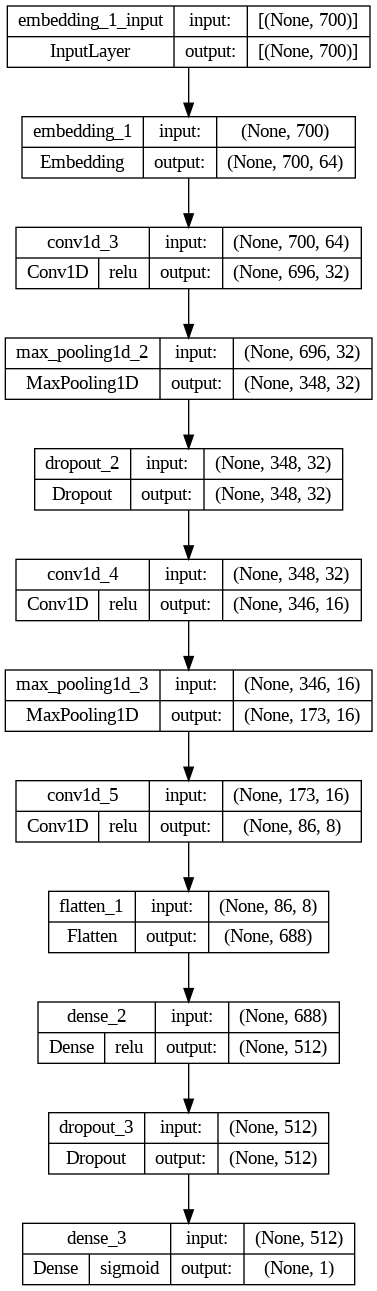

In [ ]:
# visalizing the layers of model.
import tensorflow as tf

tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)


In [ ]:
# train the model
import time as t
start = t.time()

# fitting data to model where batch size is defined as 128 and epochs set as 15. Also validating model with 10% validation values of dataset.
history = model.fit(x_train, 
                    y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_val, y_val))
print("total time in training",t.time()-start)

Epoch 1/15
36/36 [==============================] - 17s 77ms/step - loss: 0.6492 - accuracy: 0.6150 - val_loss: 0.6030 - val_accuracy: 0.6667
Epoch 2/15
36/36 [==============================] - 1s 17ms/step - loss: 0.4574 - accuracy: 0.7906 - val_loss: 0.3925 - val_accuracy: 0.8363
Epoch 3/15
36/36 [==============================] - 2s 42ms/step - loss: 0.2801 - accuracy: 0.8777 - val_loss: 0.3034 - val_accuracy: 0.8718
Epoch 4/15
36/36 [==============================] - 2s 44ms/step - loss: 0.1901 - accuracy: 0.9213 - val_loss: 0.3048 - val_accuracy: 0.8777
Epoch 5/15
36/36 [==============================] - 1s 23ms/step - loss: 0.1510 - accuracy: 0.9415 - val_loss: 0.3221 - val_accuracy: 0.8895
Epoch 6/15
36/36 [==============================] - 1s 20ms/step - loss: 0.1296 - accuracy: 0.9461 - val_loss: 0.3957 - val_accuracy: 0.8679
Epoch 7/15
36/36 [==============================] - 1s 18ms/step - loss: 0.0969 - accuracy: 0.9616 - val_loss: 0.3662 - val_accuracy: 0.8817
Epoch 8/15
3

In [ ]:
!pip install keras_flops
import keras_flops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

In [ ]:
# defining get_flops function.
def get_flops(model, batch_size=None):
    if batch_size is None:
        batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                            run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

In [ ]:
# calculating flops
flops = get_flops(model, batch_size = 128)
print(flops)
print(f"FLOPS: {flops / 10 ** 9:.03} G ")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


2066610304
FLOPS: 2.07 G 


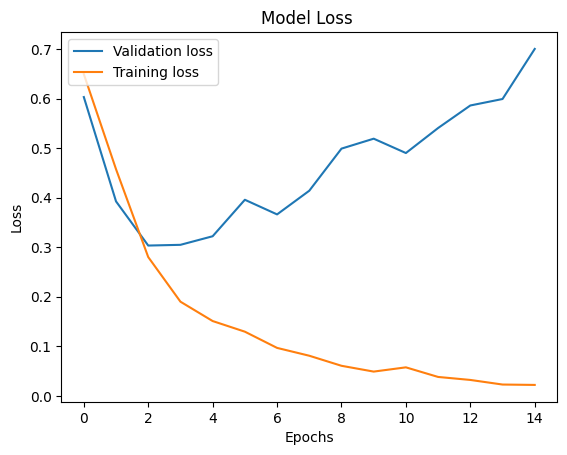

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss ')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Validation loss', 'Training loss'], loc='upper left')
plt.show()

In [ ]:
# all possible parameters history stores
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

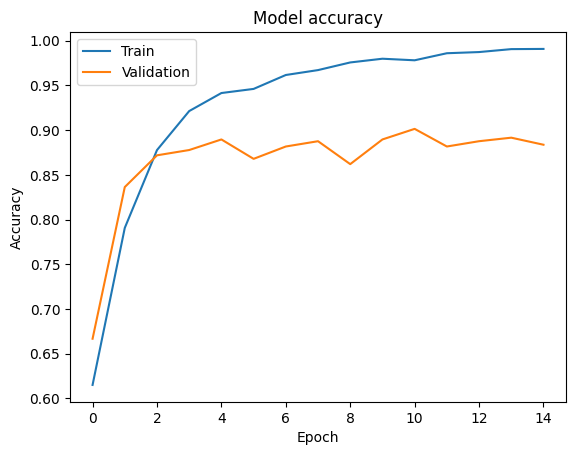

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# evaluating model
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
10/10 [==============================] - 0s 19ms/step - loss: 0.5782 - accuracy: 0.8871
test loss, test acc: [0.5781979560852051, 0.8871349692344666]


In [ ]:
# define a function that allows us to evaluate models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing accuraries are reported
    '''
    # training acc
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing acc
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    

    # accuracy = accuracy_score(y_test,y_pred_tex)
    roc_auc =roc_auc_score(y_test, y_predict_test)
    precision = precision_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)
    recall = recall_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)
    
    cr = classification_report(y_test, y_predict_test,zero_division=1)


    fpr, tpr, threshold = roc_curve(y_test, y_predict_test)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label= 'CNN')
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title('%s ROC Curve'% 'CNN',fontsize=20)
    plt.legend(fontsize=12)
    plt.show()

    roc_auc_sc = roc_auc_score(y_test,y_predict_test)

    return train_acc, test_acc,cr,roc_auc_sc

40/40 [==============================] - 0s 4ms/step


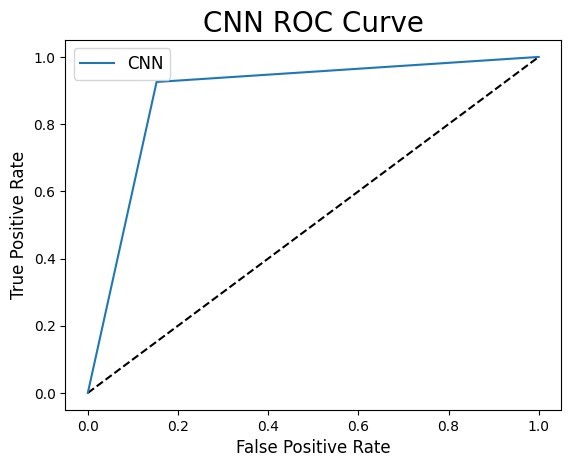

Training Accuracy: 99.28%
Testing Accuracy: 88.71%
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88       623
           1       0.86      0.93      0.89       644

    accuracy                           0.89      1267
   macro avg       0.89      0.89      0.89      1267
weighted avg       0.89      0.89      0.89      1267

AUC score 0.8864889385162955
Total testing time: 1.3106281757354736


In [ ]:
# evaluate model
import time as t
start = t.time()
train_acc, test_acc,cr,roc_auc_sc = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Classification Report:\n",cr)
print("AUC score",roc_auc_sc)
print("Total testing time:",t.time()-start)

In [ ]:
# saving the model.
model.save('/content/gdrive/MyDrive/FINAL YR PROJECT/Fake News/Model/Data/fake news cnn benchmark') 

In [ ]:
from tensorflow import keras
loaded_model = keras.models.load_model('/content/gdrive/MyDrive/FINAL YR PROJECT/Fake News/Model/Data/fake news cnn benchmark')

In [ ]:
loaded_model.evaluate(x_test,y_test)

40/40 [==============================] - 1s 5ms/step - loss: 0.5244 - accuracy: 0.8974


[0.5244473218917847, 0.8973954319953918]

In [ ]:
!pip install scikeras 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import scikeras



In [ ]:
# loading weights of cyberbullying dataset to perform weights transferred on fake news detection for experimental study.
from tensorflow import keras
loaded_model = keras.models.load_model('/content/gdrive/MyDrive/FINAL YR PROJECT/Fake News/Model/Data/cyberbullying cnn 1')

In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 64)           64064     
                                                                 
 conv1d (Conv1D)             (None, 696, 32)           10272     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 348, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 348, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 346, 16)           1552      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 173, 16)          0         
 1D)                                                    

In [ ]:
from keras.layers import Activation, Dense
model_new = Sequential()
# going through until last layer (ommitting last layer as this problem belongs to binary classification)
for layer in loaded_model.layers[:-1]: 
    model_new.add(layer)

# adding final layer with 1 neuron as this is binary classification problem and sigmoid activation function
model_new.add(Dense(1,activation = 'sigmoid'))


# compiling model
model_new.summary()
model_new.compile(optimizer='adam', loss='binary_crossentropy',metrics= ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 64)           64064     
                                                                 
 conv1d (Conv1D)             (None, 696, 32)           10272     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 348, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 348, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 346, 16)           1552      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 173, 16)          0         
 1D)                                                  

In [ ]:
# train the model
import time as t
start = t.time()

# fitting data to model where batch size is defined as 128 and epochs set as 15. Also validating model with 10% validation values of dataset.
history = model_new.fit(x_train, 
                    y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_val, y_val))
print("total time in training",t.time()-start)

Epoch 1/15
36/36 [==============================] - 5s 62ms/step - loss: 1.1069 - accuracy: 0.5950 - val_loss: 0.6232 - val_accuracy: 0.6706
Epoch 2/15
36/36 [==============================] - 1s 26ms/step - loss: 0.6306 - accuracy: 0.6650 - val_loss: 0.5911 - val_accuracy: 0.7041
Epoch 3/15
36/36 [==============================] - 2s 47ms/step - loss: 0.5653 - accuracy: 0.7233 - val_loss: 0.5364 - val_accuracy: 0.7298
Epoch 4/15
36/36 [==============================] - 2s 45ms/step - loss: 0.4834 - accuracy: 0.7689 - val_loss: 0.4602 - val_accuracy: 0.7653
Epoch 5/15
36/36 [==============================] - 2s 45ms/step - loss: 0.3627 - accuracy: 0.8338 - val_loss: 0.3651 - val_accuracy: 0.8185
Epoch 6/15
36/36 [==============================] - 1s 21ms/step - loss: 0.2693 - accuracy: 0.8884 - val_loss: 0.3110 - val_accuracy: 0.8600
Epoch 7/15
36/36 [==============================] - 1s 16ms/step - loss: 0.2107 - accuracy: 0.9149 - val_loss: 0.3470 - val_accuracy: 0.8718
Epoch 8/15
36

40/40 [==============================] - 0s 3ms/step


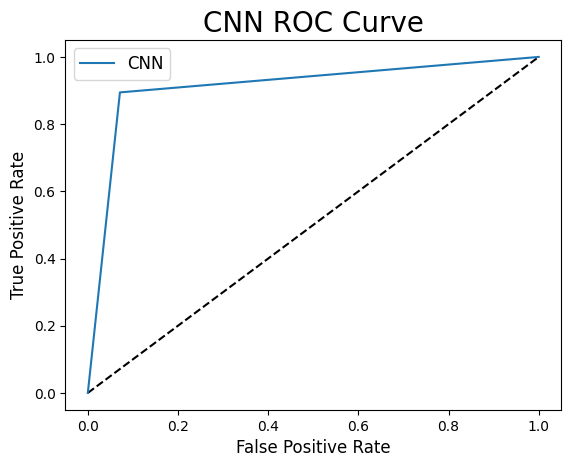

Training Accuracy: 99.87%
Testing Accuracy: 91.08%
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       604
           1       0.93      0.89      0.91       663

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267

AUC score 0.9116136266019398
Total testing time: 2.327754497528076


In [ ]:
# evaluate model
import time as t
start = t.time()
train_acc, test_acc,cr,roc_auc_sc = evaluate_model(lambda x: np.rint(model_new.predict(x)),
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Classification Report:\n",cr)
print("AUC score",roc_auc_sc)
print("Total testing time:",t.time()-start)

In [ ]:
model_new.evaluate(x_test,y_test)

40/40 [==============================] - 0s 5ms/step - loss: 0.4689 - accuracy: 0.9108


[0.4688999652862549, 0.9108129143714905]